# **Centrality Analysis**

Workflow:
1) Perform the 3 centrality analyses on entire network, commenting on features and relevance as we discover them
2) Perform same 3 analyses on the subnetwork of proteins of interest, comparing to main graph
3) Add Pathogen Nodes, Repeat steps 1 & 2 

## **Introduction** - Understanding Centrality

The structure of complex networks such as PPINs are often very heterogenous and it can be expected that some proteins will be more important than others when considering functionality, and in our case, their role in disease. The importance of these proteins can be quantified by a measure of network centrality, in which the most 'central' proteins score higher in this measure and are typically the most influential over the flow of information within the network.For this study, we will consider three different definitions of what it means for a protein to be a central in our network, and use these definitions to identify important hubs and bottlenecks which may serve as targets for therapeutic intervention. For this analysis we will be using betweenness, degree, and closeness centrality, each of which are described, along with their considerations in the next section.


## Betweenness Centrality:

Using this definition of centrality, a node is central if there are many shortest paths running through it. For example, if we imagine a metabolic network composed of various enzymes which transform basic nutrients into functional proteins and suppose we identify an enzyme that catalyzes a reaction that forms an intermediate metabolite common to all final products, we would label that protein enzyme as having a high betweenness centrality. Specifically, this measure of centrality can be described in the following formula:

$$B_{i}= \sum_{a,b}\frac{\eta(a,i,b)}{\eta(a,b)}$$

where $\eta(a,i,b)$ represents the number of shortest paths connecting nodes $\textit{a}$ and $\textit{b}$ that pass through vertex $\textit{i}$ and $\eta(a,b)$ represents the total number of shortest paths that exist between $\textit{a}$ and $\textit{b}$. This calculation of $B_{i}$ can be simply understood as the summation of the proportions of the number of node pairs in the network that include i along their connecting path out of the total number of possible paths from $\textit{a}$ to $\textit{b}$. Given this, a higher $B_{i}$ value indicates the node is more central.

Identifying proteins in our network with a high $B_{i}$ should reveal bottlenecks, where two communities are linked together by a single, or few proteins. If bottleneck proteins are disrupted, the information flow between the connected communities would likely stop, resulting in large changes in the functionality of those communities.  

##  Degree Centrality:

Defining a node as central by its degree is another common way of measuring centrality. Using this definition, a node is central if it has a high degree, meaning there are many edges connecting it. This formula can be represented as: 

$$k_{i} = \sum_{j=1}^{N}A_{ij}$$

where $\textit{i}$ is the node of interest, N is the number of nodes in the network, and j is another node within the network. This definition of centrality is better used when interested in local centrality, such as identifying major general hubs. An example of this might be identifying a signal transduction factor that is implemented in a wide variety of cellular functions. A major limitation when using this definition of centrality is that the node labeled as central may exist at the periphery of the network and not actually be located in the center, topographically. 

## Closeness Centrality:

Lastly, we will be considering the closeness definition of centrality. Under this definition, a node is considered central if it is close to all other nodes in the network. This can be calculated as the average distance of each node to all other nodes and can represented as: $$C_{i} = \frac{N}{\sum_{j=1,j\neq{i}}^{N}d_{ij}}$$ 

where $C_{i}$ is the measure of centrality at a particular node i, N is the total number of nodes in the network, and $d_{ij}$ is the length of the shortest path between i and j.

This definition is intuitive in that one might expect information in a protein network to flow through the shortest distances, and works best for networks with larger variability in path length. A drawback of this working definition is that in PPINs where the variability in average pathlength is small, defining a protein as central may be meaningless if the diameter of the network is small.

_____________________________________________________________________________________________________

# **Centrality Analysis of the Healthy Network:**

In [41]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#import graph
file = open("../Data/Macrophage_protein_network_with_attributes.pkl", "rb")
G = nx.read_gpickle(file)

## Overview:

### Here we will examine the central nodes of the healthy human macrophage protein network and determine what role they play, serving either as a hub or bottleneck. We will be applying the three different definitions of centrality described above.

### **Betweenness Centrality:**

In [8]:
#Calculating betweenness centrality: Object returned is a dictionary where keys = nodes and values = centrality score
betweenness_centralities = nx.betweenness_centrality(G)

There are 5 nodes with a betweenness centrality score that is in the top 5% 
The nodes are: ['P16401', 'Q9H257', 'P08631', 'Q02930', 'P02545']


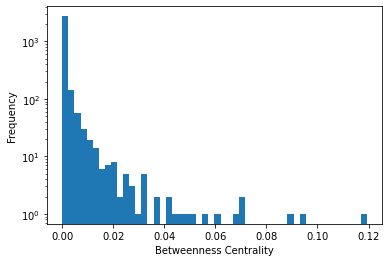

In [231]:
#sort dictionary so nodes with highest betweenness centrality are at the top
betweenness_sorted = dict(sorted(betweenness_centralities.items(), reverse = True, key=lambda x:x[1]))

#Display the range of betweenness centrality measures 
def betweenness_centrality_plot(dict):
    centrality_list = [] 
    for key,value in betweenness_sorted.items():
        centrality_list.append(value)
    plot = plt.hist(centrality_list, log=True, bins = 50)
    plt.xlabel("Betweenness Centrality")
    plt.ylabel("Frequency")
    return(plot)
betweenness_centrality_plot(betweenness_sorted); 

#Select all the outliers as well as nodes that are in the top 5% of centrality score (after exclusion of outliers)
betweenness_central_nodes = []
cutoff = 0.08 #selected by looking at distribution of centrality scores.

del_list = []
for key,value in betweenness_sorted.items(): #first pass, collect outliers
    if value >= cutoff:
        betweenness_central_nodes.append(key)
        del_list.append(key)
for node in del_list: #remove outliers from list
    del betweenness_sorted[node]

#Take top 5% of range of centrality
min_val = min(betweenness_sorted.values())
max_val = max(betweenness_sorted.values())
diff = max_val-min_val
cutoff = diff*0.95

for key,value in betweenness_sorted.items(): #Second pass, collect nodes in the top 5% of the range of centrality scores
    if value >= cutoff:
        betweenness_central_nodes.append(key)        
        
#print(betweenness_sorted)
print("There are {} nodes with a betweenness centrality score that is in the top 5% ".format(len(betweenness_central_nodes))) 
print("The nodes are: {}".format(betweenness_central_nodes))

Now that we have selected 7 nodes that have the highest betweeneness centrality, lets determine if those nodes are hubs or bottlenecks by viewing their place within the network

In [232]:
#Goal: create subgraphs for each central node, where each subgraph is the central node plus its neighbors neighbors
def second_neighbors(graph, node) -> list:
    """Takes a graph and a node of choice and returns a list of the unique neighborhood nodes of the second degree for the given node"""
    node = str(node)
    neighbor_list = []
    for first_neighbor in graph.neighbors(node):
        neighbor_list.append(first_neighbor)
        for second_neighbor in graph.neighbors(first_neighbor):
            if second_neighbor != node:
                neighbor_list.append(second_neighbor)
    #Remove duplicates
    filtered = []
    for i in neighbor_list:
        if i not in filtered:
            filtered.append(i)  
    return(filtered)

#Save each neighborhood of nodes in a dictionary where the key = the central node and the values = list of the neighorhood nodes, including both first and second neighbors
graph_list = {}
for node in betweenness_central_nodes:
    subgraph_list = second_neighbors(G,node) + list(G.neighbors(node))
    graph_list[node] = subgraph_list


No handles with labels found to put in legend.


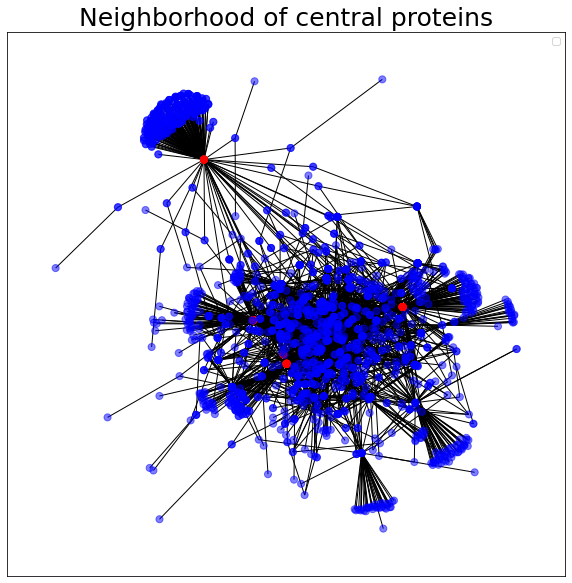

In [233]:
#Plotting all central nodes in one graph and displaying their location within the graph

#First combine all the node lists for each central node:
combined_node_list = []
for node in graph_list:
    if node not in combined_node_list:
        combined_node_list.append(node) #adds the central node
    for subnode in graph_list[node]:
        combined_node_list.append(subnode) #adds the first and second neighbors of central node

#Plot all central nodes
 
#set fig dimensions
plt.figure(figsize =(10,10))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(G, iterations=20, seed = 15)
color_map =['red' if node in betweenness_central_nodes else 'blue' for node in combined_node_list]

#Draw out neighborhood nodes of central node
nx.draw_networkx_nodes(G, 
                       pos, 
                       node_size=50,
                       alpha = 0.5,
                       nodelist = combined_node_list, 
                       node_color = color_map)


#Pull edges from main Graph that correspond to nodes in the neighborhood
edge_list1 = []
for edge in G.edges():
    if (edge[0] in combined_node_list) and (edge[1] in combined_node_list):
        edge_list1.append(edge)

#Draw Edges        
nx.draw_networkx_edges(G,pos, edgelist=edge_list1)

#Plot Labels
name = "Neighborhood of central proteins"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.legend(scatterpoints=1)

plt.show()

    
    

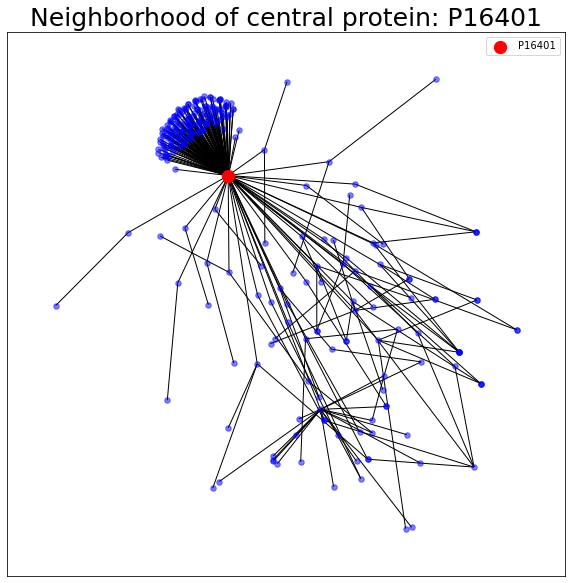

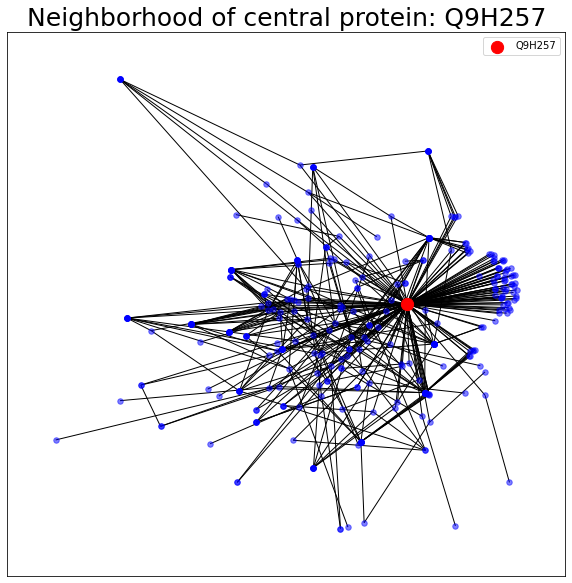

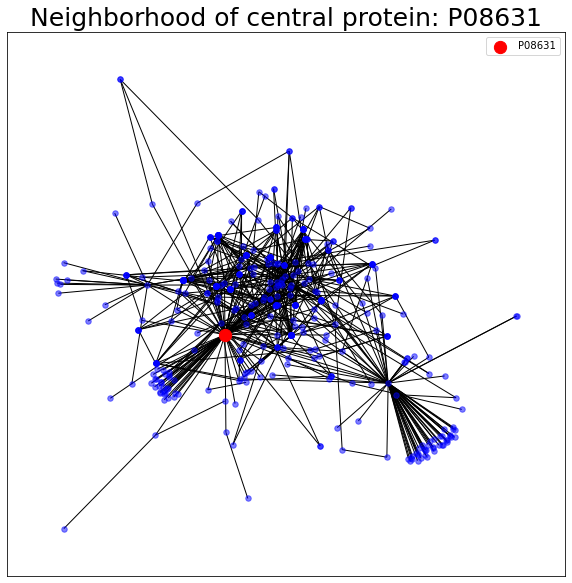

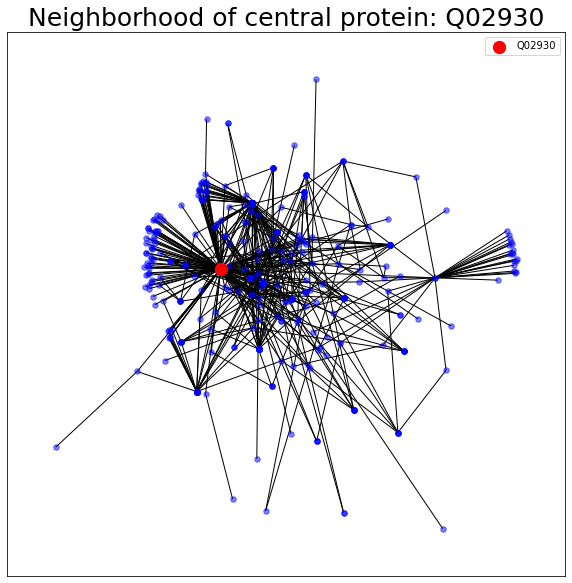

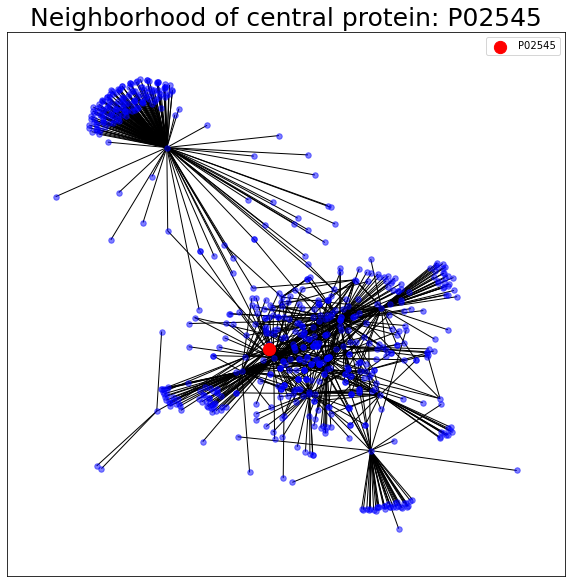

In [235]:
#Visualize the community of each central node
for node in graph_list:
    
    #set fig dimensions
    plt.figure(figsize =(10,10))

    #setting x and y coordinates for nodes and edges
    pos = nx.spring_layout(G, iterations=20, seed = 15)

    #Draw out neighborhood nodes of central node
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_size=30,
                           alpha = 0.5,
                           nodelist = graph_list[node], 
                           node_color = 'blue')

    #Place central node and color it red
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_size=150, 
                           nodelist = [node], 
                           node_color = 'red',
                           label = "{}".format(str(node))
                          )

    #Pull edges from main Graph that correspond to nodes in the neighborhood
    edge_list1 = []
    for edge in G.edges():
        if (edge[0] in graph_list[node]) and (edge[1] in graph_list[node]):
            edge_list1.append(edge)
        elif (edge[0] == node) or (edge[1] == node):
              if edge not in edge_list1:
                  edge_list1.append(edge)

    #Draw Edges        
    nx.draw_networkx_edges(G,pos, edgelist=edge_list1)
    
    #Plot Labels
    name = "Neighborhood of central protein: " + str(node)
    plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
    plt.legend(scatterpoints=1)
    
    plt.show()
    
 


### Next we will color nodes by their subcellular location to get a better view of which kinds of proteins the central nodes are interacting with.

In [212]:
#View attribute data
print(G.nodes(data=True)['Q8NI38'])


{'UniprotName': 'IKBD_HUMAN', 'GeneName': 'NFKBID', 'Gene_ontology_(biological_process)': 'inflammatory response [GO:0006954]; positive regulation of T-helper 17 cell differentiation [GO:2000321]; regulation of gene expression [GO:0010468]; T cell receptor signaling pathway [GO:0050852]', 'Gene_ontology_(molecular_function)': nan, 'Gene_ontology_(cellular_component)': 'nucleus [GO:0005634]', 'Intramembrane': nan, 'Subcellular_location_[CC]': 'SUBCELLULAR LOCATION: Nucleus {ECO:0000250|UniProtKB:Q2TB02}.', 'Topological_domain': nan, 'Pathway': nan}


### As we can see, the attribute information is messy, so first we will clean it up so that we have the attribute "location" as a single location such as nucleus, cytoplasm, etc

In [ ]:
#Cleaning up attribute data

### **Degree Centrality:**

In [236]:
#Calculating Degree Centrality
Degree_centralities = nx.degree_centrality(G)

There are 5 nodes with a degree centrality score that is in the top 5% after obvious outliers are included 
The nodes are: ['P16401', 'Q9H257', 'Q02930', 'Q8NEC5', 'Q8NI38']


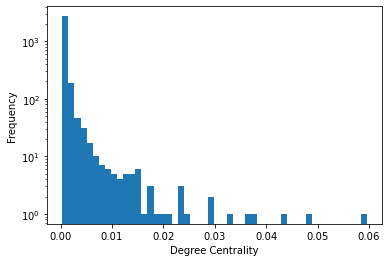

In [251]:
#sort dictionary so nodes with highest degree centrality are at the top
Degree_sorted = dict(sorted(Degree_centralities.items(), reverse = True, key=lambda x:x[1]))

#Display the distribution of Degree centrality measures 
def Degree_centrality_plot(dict):
    centrality_list = [] 
    for key,value in Degree_sorted.items():
        centrality_list.append(value)
    plot = plt.hist(centrality_list, log=True, bins = 50)
    plt.xlabel("Degree Centrality")
    plt.ylabel("Frequency")
    return(plot)

Degree_centrality_plot(Degree_sorted); 

#Select all the outliers as well as nodes that are in the top 5% of centrality score (after exclusion of outliers)
degree_central_nodes = []
cutoff = 0.04#selected by looking at distribution of centrality scores.

del_list = []
for key,value in Degree_sorted.items(): #first pass, collect outliers
    if value >= cutoff:
        degree_central_nodes.append(key)
        del_list.append(key)
for node in del_list: #remove outliers from list
    del Degree_sorted[node]

#Take top 5% of range of centrality
min_val = min(Degree_sorted.values())
max_val = max(Degree_sorted.values())
diff = max_val-min_val
cutoff = diff*0.95

for key,value in Degree_sorted.items(): #Second pass, collect nodes in the top 5% of the range of centrality scores
    if value >= cutoff:
        degree_central_nodes.append(key)        
        
#print(betweenness_sorted)
print("There are {} nodes with a degree centrality score that is in the top 5% after obvious outliers are included ".format(len(degree_central_nodes))) 
print("The nodes are: {}".format(degree_central_nodes))

No handles with labels found to put in legend.


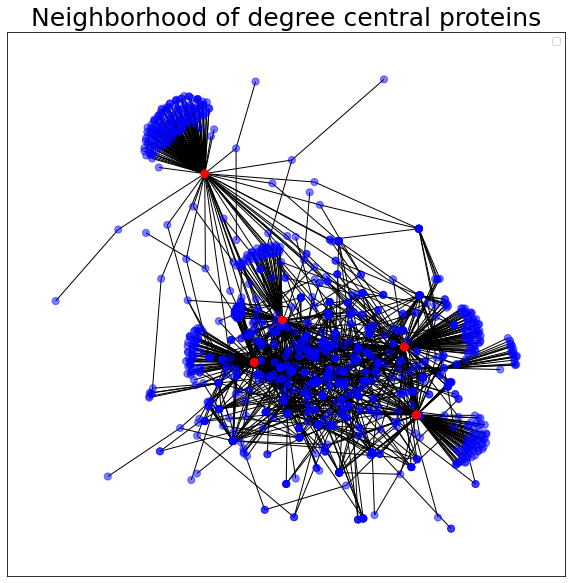

In [254]:
#Save each neighborhood of nodes in a dictionary where the key = the central node and the values = list of the neighorhood nodes, including both first and second neighbors
graph_list = {}
for node in degree_central_nodes:
    subgraph_list = second_neighbors(G,node) + list(G.neighbors(node))
    graph_list[node] = subgraph_list
    
#Plotting all degree central nodes in one graph and displaying their location within the graph

#First combine all the node lists for each central node:
combined_node_list = []
for node in graph_list:
    if node not in combined_node_list:
        combined_node_list.append(node) #adds the central node
    for subnode in graph_list[node]:
        combined_node_list.append(subnode) #adds the first and second neighbors of central node

#Plot all central nodes
 
#set fig dimensions
plt.figure(figsize =(10,10))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(G, iterations=20, seed = 15)
color_map =['red' if node in degree_central_nodes else 'blue' for node in combined_node_list]

#Draw out neighborhood nodes of central node
nx.draw_networkx_nodes(G, 
                       pos, 
                       node_size=50,
                       alpha = 0.5,
                       nodelist = combined_node_list, 
                       node_color = color_map)


#Pull edges from main Graph that correspond to nodes in the neighborhood
edge_list1 = []
for edge in G.edges():
    if (edge[0] in combined_node_list) and (edge[1] in combined_node_list):
        edge_list1.append(edge)

#Draw Edges        
nx.draw_networkx_edges(G,pos, edgelist=edge_list1)

#Plot Labels
name = "Neighborhood of degree central proteins"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.legend(scatterpoints=1)

plt.show()

    
    


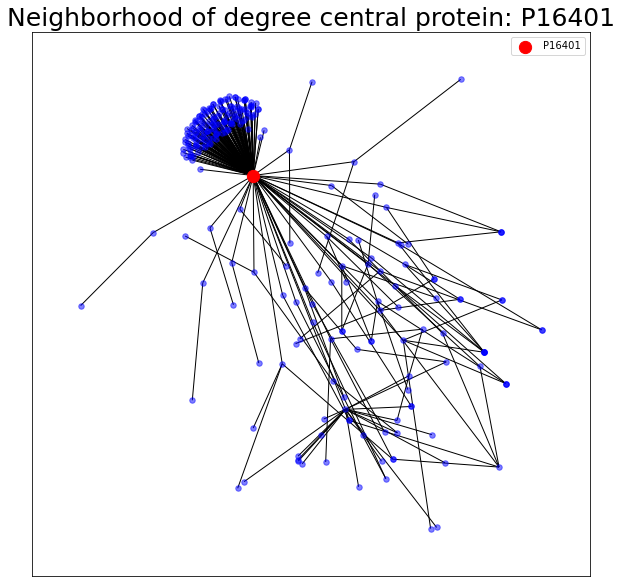

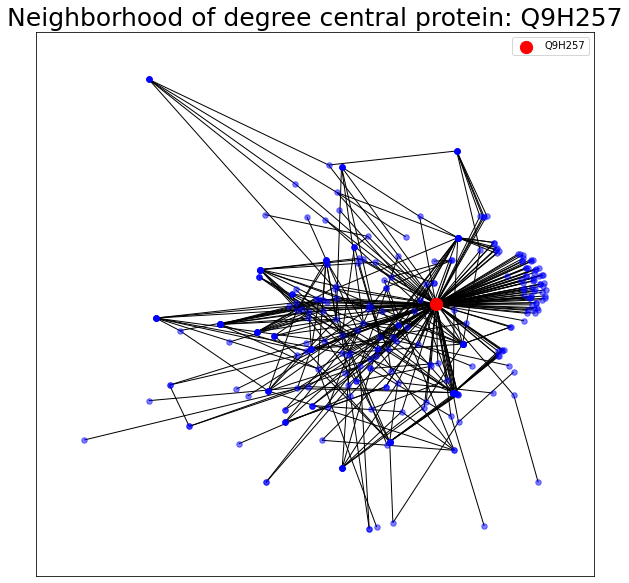

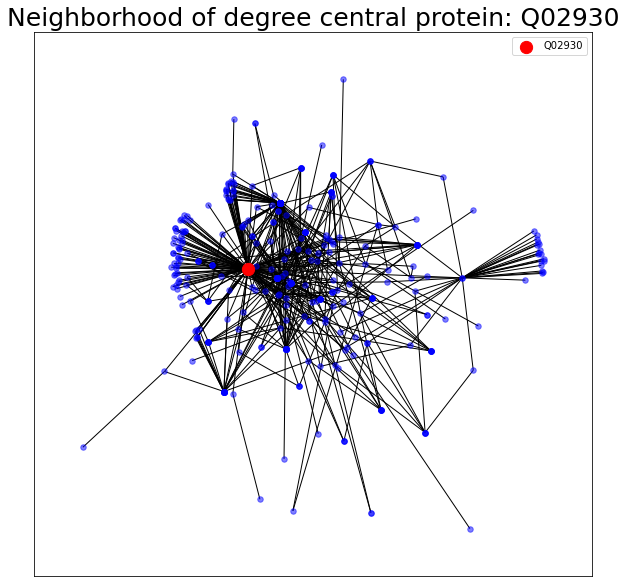

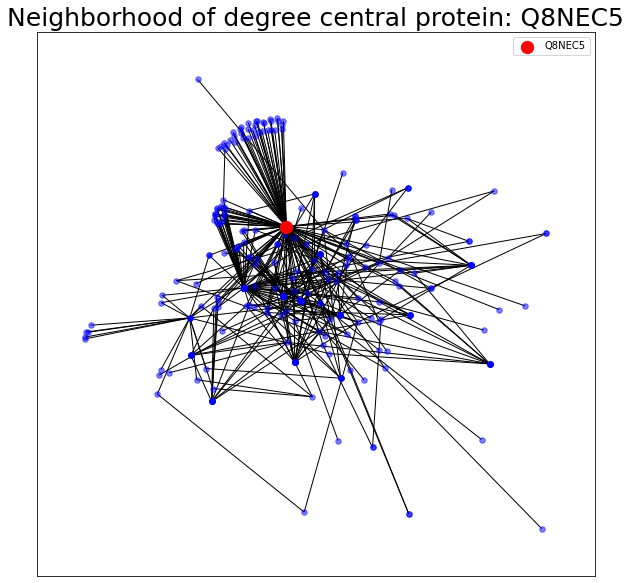

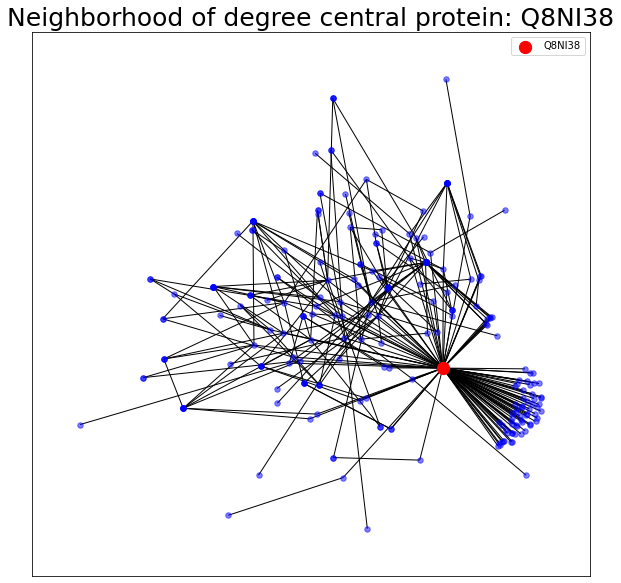

In [255]:
#Visualize the community of each central node
for node in graph_list:
    
    #set fig dimensions
    plt.figure(figsize =(10,10))

    #setting x and y coordinates for nodes and edges
    pos = nx.spring_layout(G, iterations=20, seed = 15)

    #Draw out neighborhood nodes of central node
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_size=30,
                           alpha = 0.5,
                           nodelist = graph_list[node], 
                           node_color = 'blue')

    #Place central node and color it red
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_size=150, 
                           nodelist = [node], 
                           node_color = 'red',
                           label = "{}".format(str(node))
                          )

    #Pull edges from main Graph that correspond to nodes in the neighborhood
    edge_list1 = []
    for edge in G.edges():
        if (edge[0] in graph_list[node]) and (edge[1] in graph_list[node]):
            edge_list1.append(edge)
        elif (edge[0] == node) or (edge[1] == node):
              if edge not in edge_list1:
                  edge_list1.append(edge)

    #Draw Edges        
    nx.draw_networkx_edges(G,pos, edgelist=edge_list1)
    
    #Plot Labels
    name = "Neighborhood of degree central protein: " + str(node)
    plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
    plt.legend(scatterpoints=1)
    
    plt.show()
    

### **Closeness Centrality:**

In [257]:
#Calculating Closeness Centrality
Closeness_centralities = nx.closeness_centrality(G)

There are 8 nodes with a degree centrality score that is in the top 5% after obvious outliers are included 
The nodes are: ['P08631', 'P59046', 'Q9H257', 'P02545', 'P43405', 'Q15323', 'Q6A162', 'Q9P2A4']


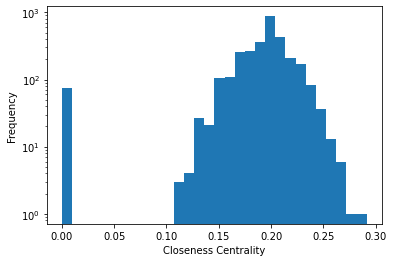

In [259]:
#sort dictionary so nodes with highest degree centrality are at the top
Closeness_sorted = dict(sorted(Closeness_centralities.items(), reverse = True, key=lambda x:x[1]))

#Display the range of Degree centrality measures 
def Closeness_centrality_plot(dict):
    centrality_list = [] 
    for key,value in Closeness_sorted.items():
        centrality_list.append(value)
    plot = plt.hist(centrality_list, log=True, bins = 30)
    plt.xlabel("Closeness Centrality")
    plt.ylabel("Frequency")
    return(plot)

Closeness_centrality_plot(Closeness_sorted); 

#Select the nodes within the top 10% of centrality score
closeness_central_nodes = []

min_val = min(Closeness_sorted.values())
max_val = max(Closeness_sorted.values())
diff = max_val-min_val
cutoff = diff*0.90

for key,value in Closeness_sorted.items(): #Second pass, collect nodes in the top 5% of the range of centrality scores
    if value >= cutoff:
        closeness_central_nodes.append(key)        
        
#print(betweenness_sorted)
print("There are {} nodes with a degree centrality score that is in the top 5% after obvious outliers are included ".format(len(closeness_central_nodes))) 
print("The nodes are: {}".format(closeness_central_nodes))

No handles with labels found to put in legend.


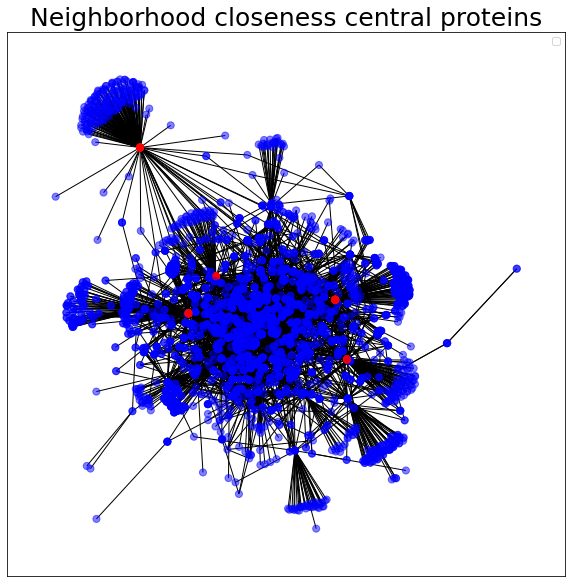

In [262]:
#Save each neighborhood of nodes in a dictionary where the key = the central node and the values = list of the neighorhood nodes, including both first and second neighbors
graph_list = {}
for node in closeness_central_nodes:
    subgraph_list = second_neighbors(G,node) + list(G.neighbors(node))
    graph_list[node] = subgraph_list
    
#Plotting all degree central nodes in one graph and displaying their location within the graph

#First combine all the node lists for each central node:
combined_node_list = []
for node in graph_list:
    if node not in combined_node_list:
        combined_node_list.append(node) #adds the central node
    for subnode in graph_list[node]:
        combined_node_list.append(subnode) #adds the first and second neighbors of central node

#Plot all central nodes
 
#set fig dimensions
plt.figure(figsize =(10,10))

#setting x and y coordinates for nodes and edges
pos = nx.spring_layout(G, iterations=20, seed = 15)
color_map =['red' if node in degree_central_nodes else 'blue' for node in combined_node_list]

#Draw out neighborhood nodes of central node
nx.draw_networkx_nodes(G, 
                       pos, 
                       node_size=50,
                       alpha = 0.5,
                       nodelist = combined_node_list, 
                       node_color = color_map)


#Pull edges from main Graph that correspond to nodes in the neighborhood
edge_list1 = []
for edge in G.edges():
    if (edge[0] in combined_node_list) and (edge[1] in combined_node_list):
        edge_list1.append(edge)

#Draw Edges        
nx.draw_networkx_edges(G,pos, edgelist=edge_list1)

#Plot Labels
name = "Neighborhood closeness central proteins"
plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
plt.legend(scatterpoints=1)

plt.show()

    
    


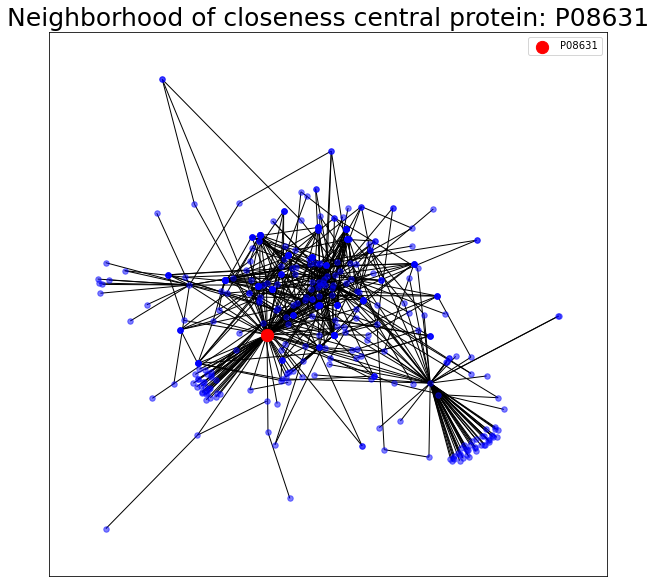

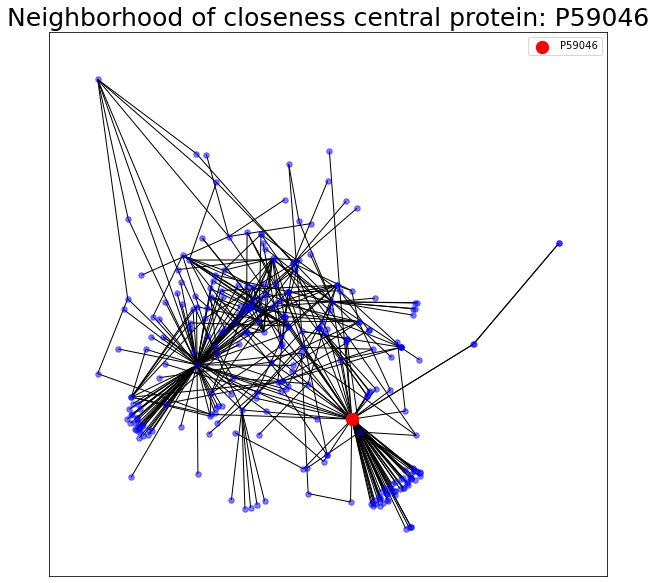

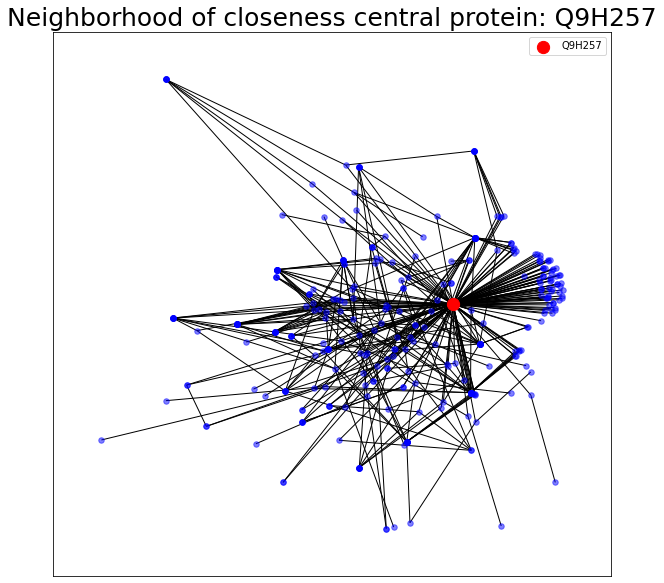

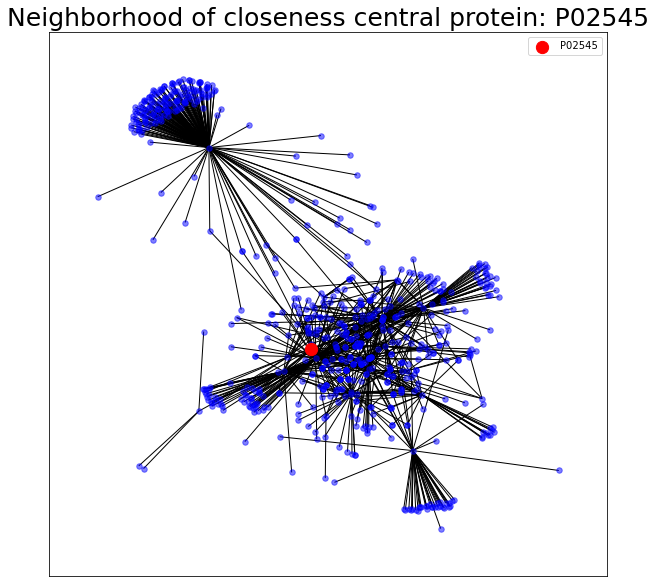

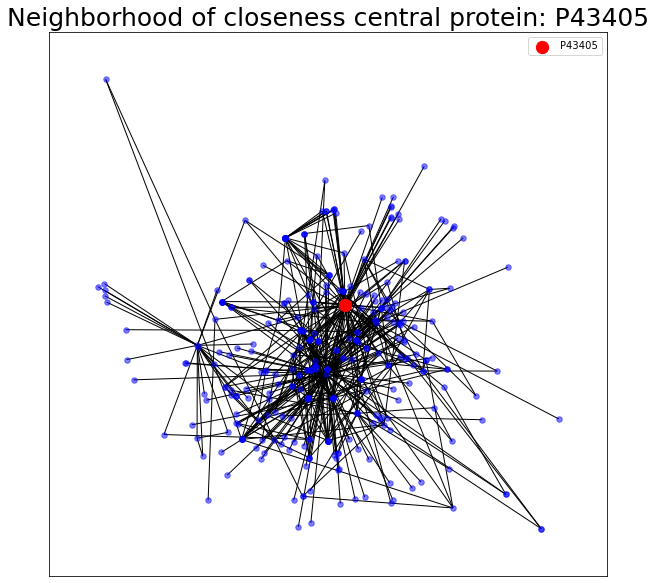

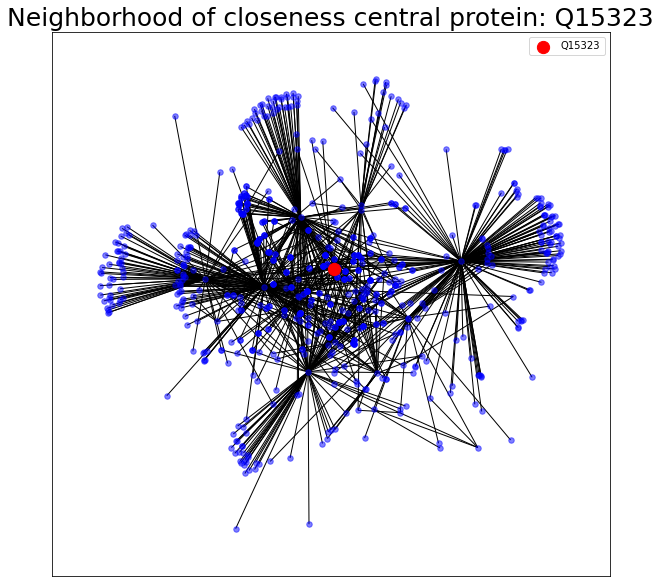

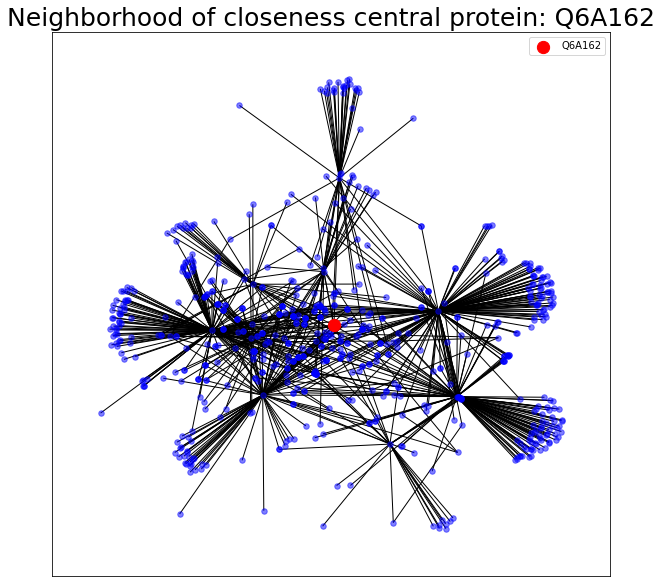

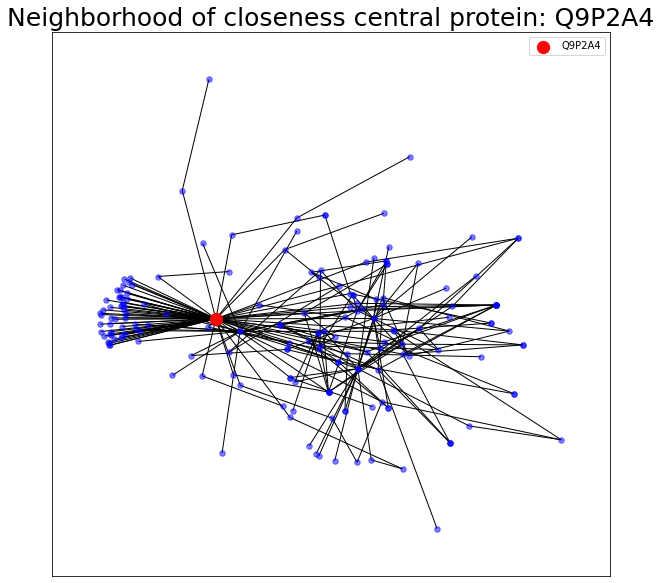

In [263]:
#Visualize the community of each central node
for node in graph_list:
    
    #set fig dimensions
    plt.figure(figsize =(10,10))

    #setting x and y coordinates for nodes and edges
    pos = nx.spring_layout(G, iterations=20, seed = 15)

    #Draw out neighborhood nodes of central node
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_size=30,
                           alpha = 0.5,
                           nodelist = graph_list[node], 
                           node_color = 'blue')

    #Place central node and color it red
    nx.draw_networkx_nodes(G, 
                           pos, 
                           node_size=150, 
                           nodelist = [node], 
                           node_color = 'red',
                           label = "{}".format(str(node))
                          )

    #Pull edges from main Graph that correspond to nodes in the neighborhood
    edge_list1 = []
    for edge in G.edges():
        if (edge[0] in graph_list[node]) and (edge[1] in graph_list[node]):
            edge_list1.append(edge)
        elif (edge[0] == node) or (edge[1] == node):
              if edge not in edge_list1:
                  edge_list1.append(edge)

    #Draw Edges        
    nx.draw_networkx_edges(G,pos, edgelist=edge_list1)
    
    #Plot Labels
    name = "Neighborhood of closeness central protein: " + str(node)
    plt.title((name), fontdict = {'fontsize': 25, "color":'black'})
    plt.legend(scatterpoints=1)
    
    plt.show()

Commonalities between all measures of centrality

In [260]:
print(betweenness_central_nodes)
print('\n')
print(degree_central_nodes)
print('\n')
print(closeness_central_nodes)

['P16401', 'Q9H257', 'P08631', 'Q02930', 'P02545']


['P16401', 'Q9H257', 'Q02930', 'Q8NEC5', 'Q8NI38']


['P08631', 'P59046', 'Q9H257', 'P02545', 'P43405', 'Q15323', 'Q6A162', 'Q9P2A4']


## Overall Conclusions

Comment on Patterns observed across all three, key things to mention

_________________________________________________________________________________

# ***Centrality Analysis of the Healthy Sub-network***

In [11]:
#Code to import all modules used for entire section - just for ease of deployment

## Overview:

overall goal for this second analysis.

## Extracting the subgraph:

Description of problem, and goal here

In [ ]:
#Code to get the subgraph out

## Betweenness Centrality:

In [ ]:
#code to do the analysis, and descriptions of findings

Comment on similiarity/ differences

## Degree Centrality:

In [ ]:
#code to do the analysis, and descriptions of findings

Comment on similiarity/differences

## Closeness Centrality:

In [ ]:
#code to do the analysis, and descriptions of findings

Comment on similiarity/differences

## Overall Conclusions:

Overall comparison of subgraph to main network

_____________________________________________________________________________________________________

# **Centrality Analysis of the Diseased Network**

In [11]:
#Code to import all modules used for entire section - just for ease of deployment

## Overview:

overall goal of this third analysis

## Adding Pathogen Nodes:

What, why, and how (remove this section if pulling diseased network from saved disease network)

In [ ]:
#Code to add nodes

## Betweenness Centrality:

In [ ]:
#Code to analyze it. talk about features as they arise

Takeaways and comparisons to healthy network

## Degree Centrality:

In [ ]:
#Code to analyze it. talk about features as they arise

Takeaways and comparisons to healthy network

## Closeness Centrality:

In [ ]:
#Code to analyze it. talk about features as they arise

Takeaways and comparisons to healthy network

## Overall Conclusions

Overall comparison of diseased whole-network to healthy whole-network

____________________________________________________________________________________________________

# **Centrality Analysis of the Diseased Sub-network**

In [11]:
#Code to import all modules used for entire section - just for ease of deployment

## Overview:

overall goal of 4th analysis

## Extracting the diseased sub-network:

description of what,why and how

In [ ]:
#Code to do it, talk about features as they arise

## Betweenness Centrality:

In [ ]:
#Code to analyze it. talk about features as they arise

Takeaways and comparisons to healthy sub-network

## Degree Centrality:

In [ ]:
#Code to analyze it. talk about features as they arise

Takeaways and comparisons to healthy sub-network

## Closeness Centrality:

In [ ]:
#Code to analyze it. talk about features as they arise

Takeaways and comparisons to healthy sub-network

## Overall Conclusions

Overall comparison of diseased whole-network to healthy whole-network

_______________________________________________________________________________________________

# **Remarks from Centrality Analysis**

What are key takeaways are from comparing all four networks?